In [1]:
import os
from glob import glob
import pickle

import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = glob('../src/data/SeaFog/*.csv')

In [3]:
data_dir.sort()

In [4]:
data_dir

['../src/data/SeaFog/302_증산도.csv',
 '../src/data/SeaFog/771_불무기도.csv',
 '../src/data/SeaFog/772_장도.csv',
 '../src/data/SeaFog/789_목포구.csv',
 '../src/data/SeaFog/SF_0008_여수 해무관측소.csv']

In [5]:
col_list = ['지점 기온(°C)',
'수온(°C)',
'강수량 1분(mm)',
'풍속(m/s)',
'u',
'v',
"현지기압(hPa)",
'해면기압(hPa)',
'습도(%)',
'일사(MJ/m^2)',
'일조(Sec)',
'T',
'해기차(T-SST)',
'이슬점온도(°C)',
'기온',
'이슬점온도(T-Td)',
'수온',
'이슬점온도(°C)',
'vis']


In [6]:
col = ['기온(°C)',
 '수온(°C)',
 '풍속(m/s)',
 'u',
 'v',
 '습도(%)',
 '해기차(T-SST)',
 '이슬점온도(°C)',
 '기온-이슬점온도(T-Td)',
 '수온-이슬점온도(°C)',
 'vis']

In [7]:
new_col = ['t', 'st', 'ws', 'u', 'v', 'h', 'astd', 
          'dp', 't-dp', 'st-dp', 'vis']

In [8]:
temp_1 = []
temp_2 = []
target_col_name = []

for ii, _dir in enumerate(data_dir):
    data = pd.read_csv(_dir, index_col=0, encoding='cp949')
    island_name = data['지점'][0]
    data = data[data.index >= '2019-12-14 09:00:00']
    data.drop('지점', axis=1, inplace=True)
    data.drop('해면기압(hPa)', axis=1, inplace=True)
    
    if ii < len(data_dir)-1:
        data.drop('일사(MJ/m^2)', axis=1, inplace=True)
        data.drop('일조(Sec)', axis=1, inplace=True)
        data.drop('1분 강수량(mm)', axis=1, inplace=True)
        data.drop('현지기압(hPa)', axis=1, inplace=True)
        data.drop('T', axis=1, inplace=True)
        
    df_1 = data[data.index <= '2021-06-01 23:50:00']
    df_2 = data[data.index >= '2021-07-01 00:00:00']


    col_name_change = {col[i]:str(island_name)+'_'+new_col[i] for i in range(len(new_col))}
    
    df_1.rename(columns=col_name_change, inplace=True)
    df_2.rename(columns=col_name_change, inplace=True)
    

    target_col_name.append(str(island_name)+'_vis')
        
    temp_1.append(df_1)
    temp_2.append(df_2)

/opt/anaconda3/envs/GraphStructureLearning/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [9]:
dataframe_1 = pd.DataFrame()

for df in temp_1:
    dataframe_1 = pd.concat([dataframe_1, df], axis=1)
    
dataframe_2 = pd.DataFrame()

for df in temp_2:
    dataframe_2 = pd.concat([dataframe_2, df], axis=1)

In [11]:
dataframe_1.dropna(inplace=True)
dataframe_2.dropna(inplace=True)

In [12]:
dataframe_1.index = pd.to_datetime(dataframe_1.index)
dataframe_2.index = pd.to_datetime(dataframe_2.index)

In [39]:
for _col in target_col_name:
    dataframe_1.loc[dataframe_1[_col] >= 2000 , _col] = 2000
    dataframe_2.loc[dataframe_2[_col] >= 2000 , _col] = 2000

In [43]:
df = pd.concat([dataframe_1, dataframe_2], axis=0)

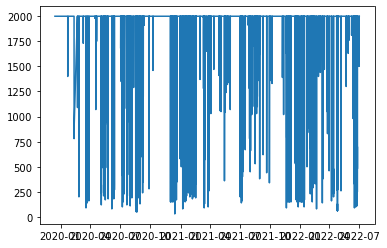

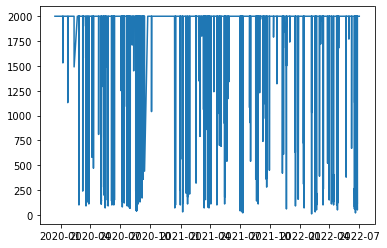

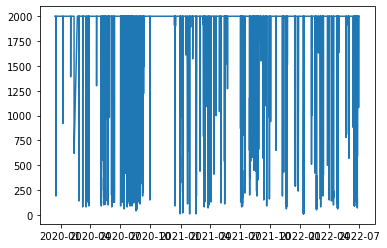

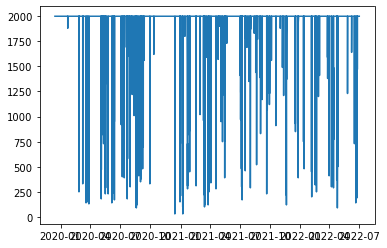

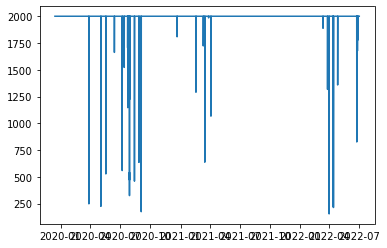

In [44]:
for _col in target_col_name:
    plt.plot(df[_col])
    plt.show()

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96391 entries, 2019-12-14 09:10:00 to 2022-06-30 23:50:00
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   302_t          96391 non-null  float64
 1   302_st         96391 non-null  float64
 2   302_ws         96391 non-null  float64
 3   302_u          96391 non-null  float64
 4   302_v          96391 non-null  float64
 5   302_h          96391 non-null  float64
 6   302_astd       96391 non-null  float64
 7   302_dp         96391 non-null  float64
 8   302_t-dp       96391 non-null  float64
 9   302_st-dp      96391 non-null  float64
 10  302_vis        96391 non-null  float64
 11  771_t          96391 non-null  float64
 12  771_st         96391 non-null  float64
 13  771_ws         96391 non-null  float64
 14  771_u          96391 non-null  float64
 15  771_v          96391 non-null  float64
 16  771_h          96391 non-null  float64
 17  771_astd       

In [47]:
num_timesteps_in = 60
num_timesteps_out = 6

indices = [
    (i, i + (num_timesteps_in + num_timesteps_out))
    for i in range(df.shape[0] - (num_timesteps_in + num_timesteps_out))
    if (df.index[i + (num_timesteps_in + num_timesteps_out)] - df.index[i]).seconds / 600 == num_timesteps_in + num_timesteps_out
]

In [48]:
len(indices)

51274

In [49]:
indices

[(0, 66),
 (1, 67),
 (68, 134),
 (69, 135),
 (70, 136),
 (71, 137),
 (72, 138),
 (73, 139),
 (74, 140),
 (75, 141),
 (76, 142),
 (77, 143),
 (78, 144),
 (79, 145),
 (146, 212),
 (147, 213),
 (148, 214),
 (149, 215),
 (274, 340),
 (275, 341),
 (276, 342),
 (277, 343),
 (278, 344),
 (279, 345),
 (280, 346),
 (281, 347),
 (282, 348),
 (283, 349),
 (284, 350),
 (285, 351),
 (286, 352),
 (819, 885),
 (820, 886),
 (821, 887),
 (1030, 1096),
 (1031, 1097),
 (1032, 1098),
 (1033, 1099),
 (1034, 1100),
 (1035, 1101),
 (1036, 1102),
 (1037, 1103),
 (1038, 1104),
 (1119, 1185),
 (1120, 1186),
 (1121, 1187),
 (1122, 1188),
 (1123, 1189),
 (1124, 1190),
 (1125, 1191),
 (1126, 1192),
 (1127, 1193),
 (1128, 1194),
 (1129, 1195),
 (1130, 1196),
 (1131, 1197),
 (1132, 1198),
 (1133, 1199),
 (1134, 1200),
 (1135, 1201),
 (1136, 1202),
 (1137, 1203),
 (1138, 1204),
 (1139, 1205),
 (1140, 1206),
 (1141, 1207),
 (1142, 1208),
 (1143, 1209),
 (1144, 1210),
 (1145, 1211),
 (1473, 1539),
 (1474, 1540),
 (1475

In [52]:
import random

In [53]:
random.shuffle(indices)

In [54]:
col_names = df.columns
index_val = df.index

In [55]:
col_names

Index(['302_t', '302_st', '302_ws', '302_u', '302_v', '302_h', '302_astd',
       '302_dp', '302_t-dp', '302_st-dp', '302_vis', '771_t', '771_st',
       '771_ws', '771_u', '771_v', '771_h', '771_astd', '771_dp', '771_t-dp',
       '771_st-dp', '771_vis', '772_t', '772_st', '772_ws', '772_u', '772_v',
       '772_h', '772_astd', '772_dp', '772_t-dp', '772_st-dp', '772_vis',
       '789_t', '789_st', '789_ws', '789_u', '789_v', '789_h', '789_astd',
       '789_dp', '789_t-dp', '789_st-dp', '789_vis', 'SF_0008_t', 'SF_0008_st',
       'SF_0008_ws', 'SF_0008_u', 'SF_0008_v', 'SF_0008_h', 'SF_0008_astd',
       'SF_0008_dp', 'SF_0008_t-dp', 'SF_0008_st-dp', 'SF_0008_vis'],
      dtype='object')

In [57]:
import sys

sys.path.append('../src')

In [ ]:
        features, target, anomaly = [], [], []

        for i, j in indices:
            features.append(self.dataframe.iloc[i: i + num_timesteps_in].T)
            target.append(self.dataframe.iloc[i + num_timesteps_in: j].T)

        features = torch.FloatTensor(np.array(features))
        targets = torch.FloatTensor(np.array(target))